In [1]:
import re
import pandas as pd
from geonamescache import GeonamesCache
from unidecode import unidecode
from operator import itemgetter

headlines = './data/headlines.txt'

class LocationExtractor:
    """Class to pull City and Country names from a string"""
    
    geocache = GeonamesCache()
    city_regex = None
    country_regex = None
    countries = {}
    country_codes = {}
    recoded = {}
    
    def __init__(self):
        gc = GeonamesCache()
        self.countries = self.geocache.get_countries_by_names()
        cities = self.geocache.get_cities()
        
        country_names = []
        city_names = []
        
        for c in cities.values():
            cname = unidecode( c['name'].lower() )
            self.recoded[cname] = c['name']
            if( cname != 'of' ):
                city_names.append( r"\b" + cname + r"\b" )

        for cname in self.countries.keys():
            country_names.append( r"\b" + unidecode( cname ) + r"\b" )
            self.country_codes[self.countries[cname]['iso']] = cname
            
        self.city_regex = self.regex_from_list( city_names )
        self.country_regex = self.regex_from_list( country_names )
        #print( f"Regex has len {len(str(self.city_regex))} and looks like\n\n{self.city_regex}" )
    
    def find_cities( self, city_str ):
        found_cities = []
        matches = self.city_regex.findall( city_str )
        if( matches ):
            for c in matches[0]:
                if( c ):
                    for x in self.geocache.get_cities_by_name( self.recoded[c.lower()] ):
                        for a, b in x.items():
                            found_cities.append( b )
        #else:
        #    print( f"\nno matches in \n{city_str}" )
        return found_cities
    
    def find_countries( self, country_str ):
        """Searches a string for names of countries and returns the name"""
        found_countries = []
        #breakpoint()
        matches = self.country_regex.search( country_str )
        if( matches ):
            for c in matches.groups():
                found_countries.append( self.countries[c] )
        return found_countries
            
    def regex_from_list( self, rarray ):
        # ensure unique & sort by length (so Witchita Falls is tried before Wichita)
        rarray = sorted( rarray, key=len)
        rarray.reverse()

        regex = "(" + "|".join( rarray ) + ')'
        rc = re.compile( regex, re.IGNORECASE )
        return rc
    
    def select_key_city( self, cities ):
        """Determines most important from a list of cities. 
        Prioritizes capital cities 1st, then greatest population"""
        prospects = []
        # See which are capitals
        for c in cities:
            country = self.countries[ self.country_codes[ c['countrycode'] ] ]
            if( c['name'] == country['capital']):
                prospects.append( c )
        if( len( prospects ) > 0 ):
            cities = prospects
        
        if( len( cities ) > 1):
            # sort by pop, but later
            cities = sorted( cities, key=itemgetter('population') )
        key = cities.pop()
        return key
    
    def find_location(self, sentence ):
        """Given a string return a tuple (string, city, country, latitude, longitude) of the location in it"""
        retval = (sentence, None, None, None, None)
        key_city = None
        sentence = unidecode( sentence )
        #breakpoint()
        countries = self.find_countries( sentence )
        cities = self.find_cities( sentence )
        select_cities = []
        if( countries ):
            if( len(cities) < 1 ):
                #print( f"No city found for {countries}")
                caps = [c['capital'] for c in countries]
                for c in caps:
                    #FIXME - breaks on multiple countries
                    cities = self.find_cities( c )
            codes = [c['iso'] for c in countries]
            select_cities = [ct for ct in cities if ct['countrycode'] in codes ]
            #print( f"Cities in {codes}:\n{select_cities}")
        elif(cities):
            #city, but no country found
            select_cities = cities
            
        if( len( select_cities) == 1 ):
            key_city = select_cities.pop()
        elif( len(select_cities) > 1):
            # need to find the actual real city
            #print( f"{len(select_cities)} cities found!")
            key_city = self.select_key_city( select_cities )
        
        if( key_city):
             retval = (sentence, key_city['name'], key_city['countrycode'], key_city['latitude'], key_city['longitude'])
        
        return retval


In [2]:
le = LocationExtractor()
rows = []
count = 0
found = 0

In [3]:
for line in open( headlines ):
    tup = le.find_location( unidecode( line.strip() ) )
    if( tup[3] ):
        found += 1
        # only adding found rows
        rows.append( tup )
    count += 1

In [4]:
df = pd.DataFrame( rows, columns = ( "headline", "city", "country", "latitude", "longitude" ) )
#df.head(4)

In [5]:
# need some dataframe metrics in here
print( f"Found {found} cities in {count} rows")

Found 611 cities in 650 rows


In [6]:
from sklearn.cluster import KMeans

num_clusters = int( len(df)/60 )
clusters = KMeans(n_clusters= num_clusters )

assigned_clusters = clusters.fit_predict( df[['latitude', 'longitude']] )
df['Cluster'] = assigned_clusters
colors = [ 'b', 'c', 'r', 'g', 'm', 'y', 'k', 'w', 'b', 'c' ]
df['Color'] = [colors[f%len(colors)] for f in df['Cluster']]

print( f"Output with {num_clusters} clusters")
df.head()

Output with 10 clusters


,headline,city,country,latitude,longitude,Cluster,Color
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,7,w
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,6,k
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,7,w
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111,0,b
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,1,c


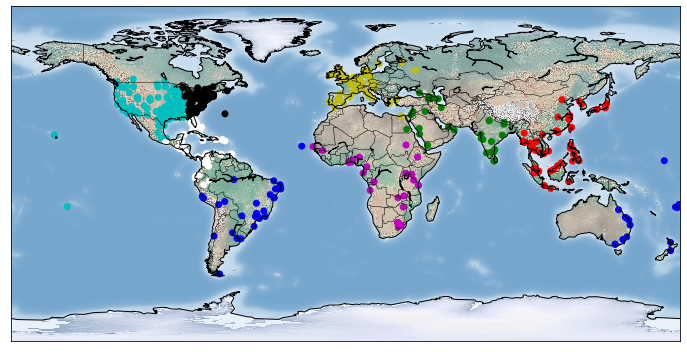

In [7]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map_plotter = Basemap()

fig = plt.figure(figsize=(12, 8))
map_plotter.drawcoastlines()
map_plotter.drawcountries()
map_plotter.shadedrelief()
map_plotter.scatter( df['longitude'], df['latitude'], latlon = True, color = df['Color'] )
plt.show()

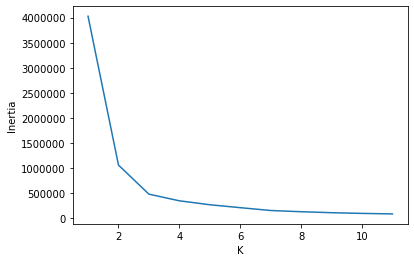

In [8]:
k_values = range(1, 12)
inertia_values = [KMeans(k).fit(df[['latitude', 'longitude']]).inertia_
                  for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()